<a href="https://colab.research.google.com/github/TylerScaringella/Chat-Room/blob/master/Swatting_Binary_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [189]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import csv
import os

In [172]:
calls = []
flag = []
with open('911_metadata.csv', mode='r', encoding='utf-8') as file:
    r = csv.reader(file)
    for lines in r:
        calls.append(lines)

# potential death index = 7
# file name index = 10
# title index = 2

print(f'Header: {calls[0]}')
print(calls[0][2])

flags = [
    'shooting',
    'murder',
    'suicide',
    'domestic',
    'abuse'
]

for call in calls:
    if call[2] is not None:
        for keyword in flags:
            if keyword in call[2].lower():
                flag.append(call[10])

print(f'flagged {len(flag)} calls')

Header: ['id', 'link', 'title', 'date', 'state', 'civilian_initiated', 'deaths', 'potential_death', 'false_alarm', 'description', 'file_name']
title
flagged 320 calls


In [205]:
docs = []
names = []
labels = []

authentic_limit = 300 # set this to the amount of authentic calls there should be
authentic_count = 0

for filename in os.listdir('./transcriptions'):
    with open(f'./transcriptions/{filename}', 'r', encoding='utf-8') as f:
        # 0 - authentic | 1 - hoax
        authentic = filename.replace('.txt', '.mp3') in flag or "real" in filename.lower()
        label = 0 if authentic == True else 1
        if "call_" in filename and label == 1:
          continue
        if label == 0:
          authentic_count += 1

        if authentic_count <= authentic_limit or label == 1:
          docs.append(f.read()
                      .replace("\n", " "))
          names.append(filename)

          labels.append(label)
          # labels.append('authentic' if label == 0 else 'hoax')
print(len(docs))

332


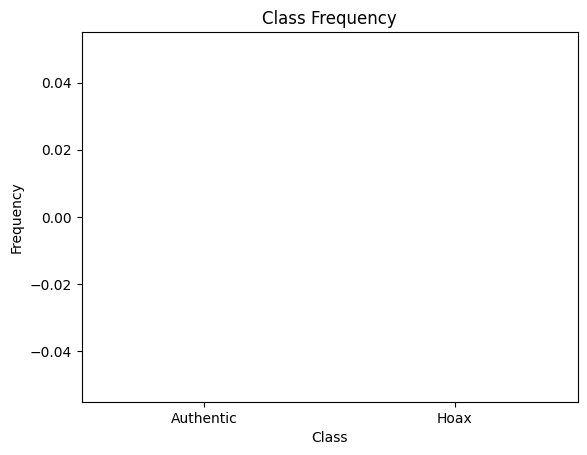

In [206]:
class_counts = {0: labels.count('authentic'), 1: labels.count('hoax')}

plt.bar(class_counts.keys(), class_counts.values(), color=['green', 'red'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency')
plt.xticks(list(class_counts.keys()), ['Authentic', 'Hoax'])
plt.show()

In [207]:
train_data, test_data, train_labels, test_labels = train_test_split(
    docs, labels, test_size=0.20, random_state=42)

In [208]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_train_data = tfidf_vectorizer.fit_transform(train_data)

count_model = make_pipeline(CountVectorizer(), SVC(kernel='linear'))
# tfidf_model = make_pipeline(TfidfVectorizer(), SVC(kernel='linear'))
tfidf_model = SVC(kernel = 'linear')
# model = make_pipeline(CountVectorizer(), SVC(kernel='linear'))

In [209]:
count_model.fit(train_data, train_labels)
# tfidf_model.fit(train_data, train_labels)
tfidf_model.fit(tfidf_train_data, train_labels)

SVC(kernel='linear')

In [210]:
tfidf_test_data = tfidf_vectorizer.transform(test_data)
decision_scores = tfidf_model.decision_function(tfidf_test_data)

count_preds = count_model.predict(test_data)
# tfidf_preds = tfidf_model.predict(test_data)
tfidf_preds = tfidf_model.predict(tfidf_test_data)

In [211]:
count_accuracy = accuracy_score(test_labels, count_preds)
tfidf_accuracy = accuracy_score(test_labels, tfidf_preds)

print(f'Count Accuracy: {count_accuracy:.2f}')
print(f'Tfidf Accuracy: {tfidf_accuracy:.2f}')

Count Accuracy: 0.94
Tfidf Accuracy: 0.97


In [212]:
print('Count', classification_report(test_labels, count_preds))
print('Tfidf', classification_report(test_labels, tfidf_preds))

Count               precision    recall  f1-score   support

           0       1.00      0.94      0.97        62
           1       0.56      1.00      0.71         5

    accuracy                           0.94        67
   macro avg       0.78      0.97      0.84        67
weighted avg       0.97      0.94      0.95        67

Tfidf               precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       1.00      0.60      0.75         5

    accuracy                           0.97        67
   macro avg       0.98      0.80      0.87        67
weighted avg       0.97      0.97      0.97        67



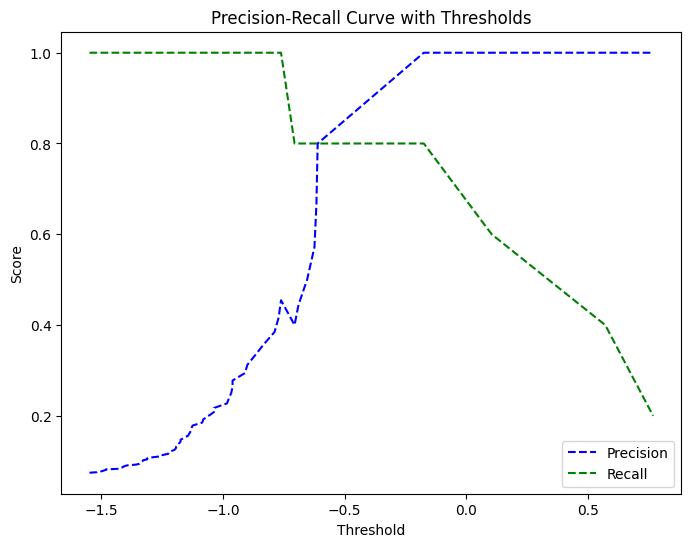

In [213]:
# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(test_labels, decision_scores)

# Calculate Area Under the Curve (AUC)
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue', linestyle='dashed')
plt.plot(thresholds, recall[:-1], label='Recall', color='green', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve with Thresholds')
plt.legend(loc='best')
plt.show()